# Digit recognizer prepared by
### Ediz Emektas and Julian Oliveros

# Import data and libraries

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [16]:
df = pd.read_csv('./train.csv')

In [17]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_pixel = df.drop('label', axis=1)

In [19]:
df_pixel.shape

(42000, 784)

# Image visualisation (EXAMPLES)

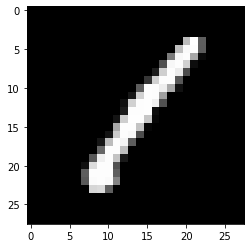

In [20]:
img = df_pixel.iloc[0].values.reshape(28, 28)
plt.imshow(img, cmap='gray')
plt.show()

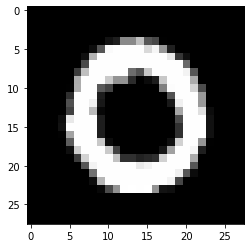

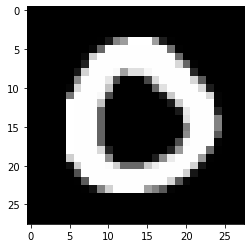

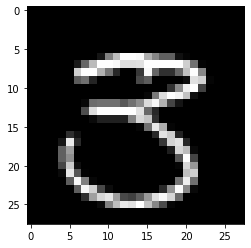

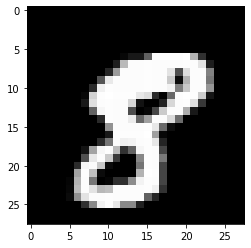

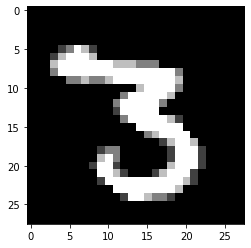

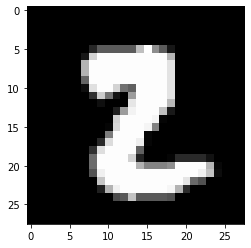

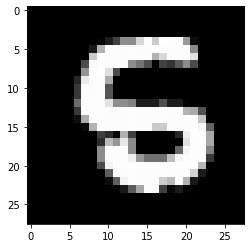

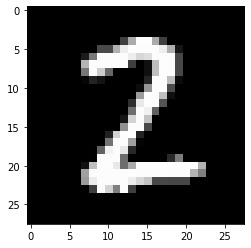

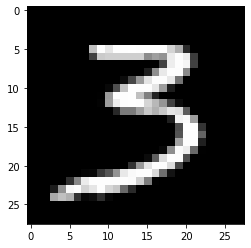

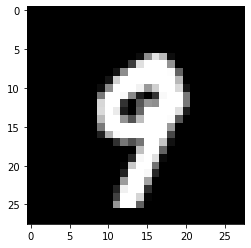

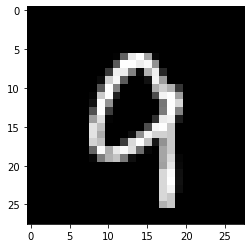

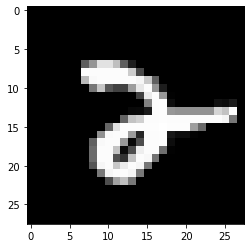

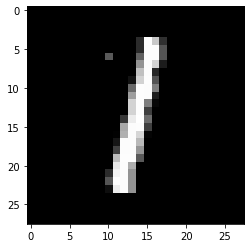

In [21]:
for i in range(1,40,3):
    plt.figure()
    plot= df_pixel.iloc[i].values.reshape(28, 28)
    plt.imshow(plot,cmap='gray')
plt.show()

# Data split

In [22]:
X = df_pixel.values
y = df['label'].values

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Outliers detection

In [24]:
model = svm.SVC(probability=True)
model.fit(X_train, y_train)
print("accuracy: " + str(model.score(X_test, y_test)))

accuracy: 0.9740952380952381


In [25]:
# confusion matrix to get outliers
from sklearn.metrics import confusion_matrix

y_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

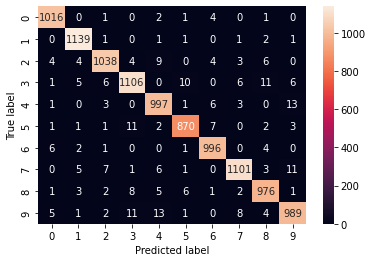

In [26]:
# confusion matrix in heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Dimension reduction

In [27]:
clf_without_dim_reduct = svm.SVC()
clf_without_dim_reduct.fit(X_train, y_train)

SVC()

In [28]:
print("accuracy: " + str(clf_without_dim_reduct.score(X_test, y_test)))

accuracy: 0.9740952380952381


In [29]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [30]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [31]:
print("y_train reduced shape: " + str(y_train.shape))
print("y_test reduced shape: " + str(y_test.shape))
print("X_recovered shape: " + str(X_recovered.shape))
print("X_reduced shape: " + str(X_reduced.shape))

y_train reduced shape: (31500,)
y_test reduced shape: (10500,)
X_recovered shape: (31500, 784)
X_reduced shape: (31500, 153)


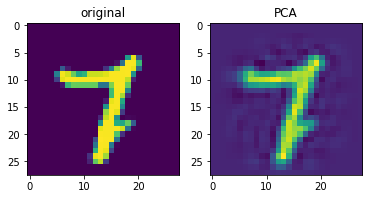

In [40]:
# Before and after PCA()
fig = plt.figure()
fig.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((28,28)))
fig.add_subplot(1,2, 2)

plt.title("PCA")
plt.imshow(X_recovered[0].reshape((28,28)))
plt.show(block=True)

# Classification model

In [32]:
clf_Dim_reduced = svm.SVC()
clf_Dim_reduced.fit(X_reduced, y_train)

SVC()

In [33]:
X_test_reduced = pca.transform(X_test)
print("accuracy: " + str(clf_Dim_reduced.score(X_test_reduced, y_test)))

accuracy: 0.9781904761904762


# Pipeline for the final working solution

In [34]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('svc', svm.SVC())])
pipe.fit(X_train, y_train)

print( "accuracy: " + str( pipe.score(X_test, y_test)))


accuracy: 0.9740952380952381


In [35]:
pca = PCA()
pipe = Pipeline([('pca', pca),('svc', svm.SVC())])
pipe.fit(X_train, y_train)

print( "accuracy: " + str( pipe.score(X_test, y_test)))

accuracy: 0.9777142857142858


# Kaggle Submission Format

In [36]:
test_df = pd.read_csv('./test.csv')
pred = pipe.predict(test_df)

/Users/zx/miniconda3/envs/FSAML/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [37]:
pred

array([2, 0, 9, ..., 3, 9, 2])

In [39]:
sub_df = pd.DataFrame(pred)
sub_df.index.name = 'ImageId'
sub_df.index += 1
sub_df.columns = ['Label']
sub_df.to_csv('submission.csv', header=True)